In [3]:
import pandas as pd
import numpy as np

flow_data = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/flows.csv")

# Add noise to the flow numbers
noise = np.random.normal(loc=0, scale=0.1, size=flow_data['flow'].shape)
flow_data['flow'] = flow_data['flow'] * (1 + noise)

# Ensure no negative flow values
flow_data['flow'] = flow_data['flow'].clip(lower=0)

# Convert flow values to integers
flow_data['flow'] = flow_data['flow'].astype(int)

# Save the modified data to a new CSV file
flow_data.to_csv('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/generated-flow.csv', index=False)

print('Dummy data with noise has been saved to generated-flow.csv')

Dummy data with noise has been saved to generated-flow.csv


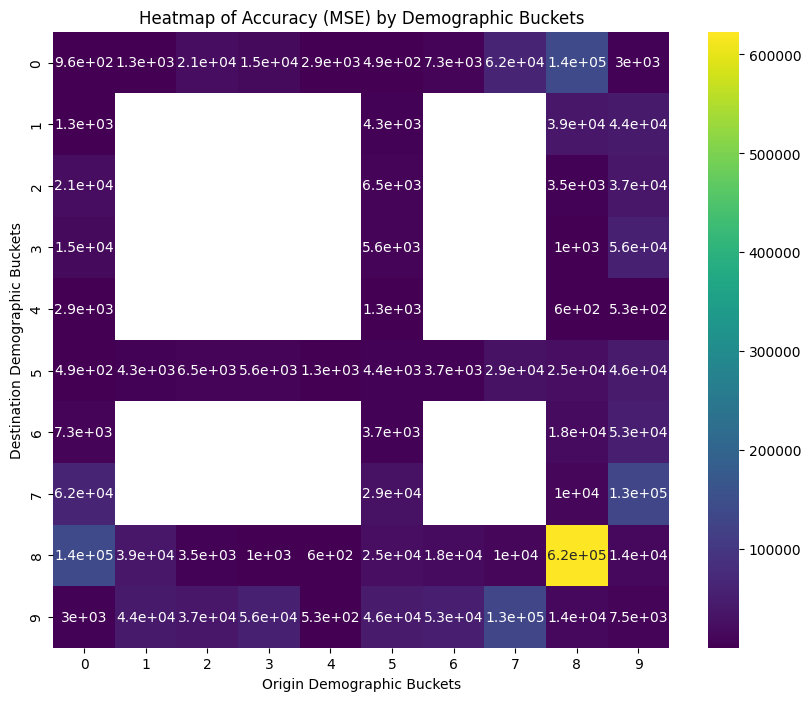

Fairness Metric (Variance of Accuracy): 721291729356.7418


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluate_fairness(flows_path, generated_flows_path, features_path, demographic_column):
    # Load data
    flows = pd.read_csv(flows_path)
    generated_flows = pd.read_csv(generated_flows_path)
    features = pd.read_csv(features_path)
    
    # Create demographic buckets
    features['bucket'] = pd.qcut(features[demographic_column], q=10, labels=False)

    # Map geoids to buckets
    geoid_to_bucket = dict(zip(features['GEOID'], features['bucket']))

    # Assign flow pairs to buckets
    def get_bucket_pair(row):
        origin_bucket = geoid_to_bucket.get(row['origin'], -1)
        destination_bucket = geoid_to_bucket.get(row['destination'], -1)
        if origin_bucket > destination_bucket:
            origin_bucket, destination_bucket = destination_bucket, origin_bucket
        return origin_bucket, destination_bucket
    
    flows['bucket_pair'] = flows.apply(get_bucket_pair, axis=1)
    generated_flows['bucket_pair'] = generated_flows.apply(get_bucket_pair, axis=1)
    
    # Merge the flows on origin and destination to ensure correct pairing
    merged_flows = pd.merge(flows, generated_flows, on=['origin', 'destination'], suffixes=('_real', '_gen'))

    # Calculate accuracy for each bucket
    mse_per_bucket = {}
    
    for bucket_pair in flows['bucket_pair'].unique():
        if bucket_pair == (-1, -1):
            continue
        
        real_flows = merged_flows[merged_flows['bucket_pair_real'] == bucket_pair]['flow_real']
        gen_flows = merged_flows[merged_flows['bucket_pair_gen'] == bucket_pair]['flow_gen']
        
        if len(real_flows) > 0 and len(gen_flows) > 0:
            mse = mean_squared_error(real_flows, gen_flows)
            mse_per_bucket[bucket_pair] = mse
    
    # Create a 10x10 matrix of accuracy
    accuracy_matrix = np.full((10, 10), np.nan)
    
    for (i, j), mse in mse_per_bucket.items():
        accuracy_matrix[i, j] = mse
        accuracy_matrix[j, i] = mse

    # Define fairness as the variance of accuracy across buckets
    fairness = np.nanvar(list(mse_per_bucket.values()))

    # Plot heatmap of accuracy
    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracy_matrix, annot=True, cmap='viridis', cbar=True, square=True)
    plt.title('Heatmap of Accuracy (MSE) by Demographic Buckets')
    plt.xlabel('Origin Demographic Buckets')
    plt.ylabel('Destination Demographic Buckets')
    plt.show()
    
    return fairness

# Example usage
flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/flows.csv'
generated_flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/generated-flows.csv'
features_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

fairness = evaluate_fairness(flows_path, generated_flows_path, features_path, demographic_column)
print(f'Fairness Metric (Variance of Accuracy): {fairness}')


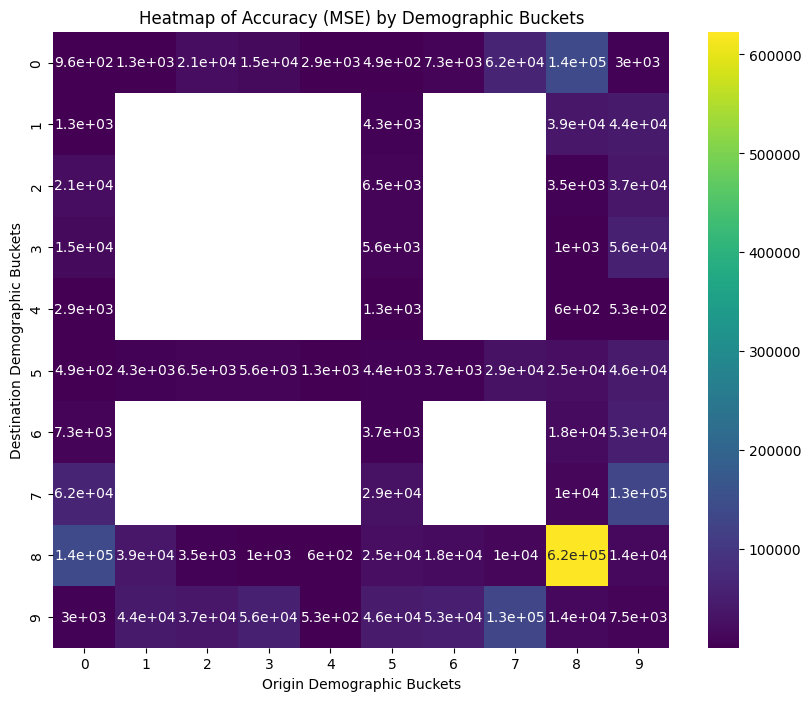

Fairness Metric (Variance of Accuracy): 721291729356.7418


In [8]:
flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/flows.csv'
generated_flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/generated-flows.csv'
features_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

# Load data
flows = pd.read_csv(flows_path)
generated_flows = pd.read_csv(generated_flows_path)
features = pd.read_csv(features_path)

# Create demographic buckets
features['bucket'] = pd.qcut(features[demographic_column], q=10, labels=False)

# Map geoids to buckets
geoid_to_bucket = dict(zip(features['GEOID'], features['bucket']))

# Assign flow pairs to buckets
def get_bucket_pair(row):
    origin_bucket = geoid_to_bucket.get(row['origin'], -1)
    destination_bucket = geoid_to_bucket.get(row['destination'], -1)
    if origin_bucket > destination_bucket:
        origin_bucket, destination_bucket = destination_bucket, origin_bucket
    return origin_bucket, destination_bucket

flows['bucket_pair'] = flows.apply(get_bucket_pair, axis=1)
generated_flows['bucket_pair'] = generated_flows.apply(get_bucket_pair, axis=1)

# Merge the flows on origin and destination to ensure correct pairing
merged_flows = pd.merge(flows, generated_flows, on=['origin', 'destination'], suffixes=('_real', '_gen'))

# Calculate accuracy for each bucket
mse_per_bucket = {}

for bucket_pair in flows['bucket_pair'].unique():
    if bucket_pair == (-1, -1):
        continue
    
    real_flows = merged_flows[merged_flows['bucket_pair_real'] == bucket_pair]['flow_real']
    gen_flows = merged_flows[merged_flows['bucket_pair_gen'] == bucket_pair]['flow_gen']
    
    if len(real_flows) > 0 and len(gen_flows) > 0:
        mse = mean_squared_error(real_flows, gen_flows)
        mse_per_bucket[bucket_pair] = mse

# Create a 10x10 matrix of accuracy
accuracy_matrix = np.full((10, 10), np.nan)

for (i, j), mse in mse_per_bucket.items():
    accuracy_matrix[i, j] = mse
    accuracy_matrix[j, i] = mse

# Define fairness as the variance of accuracy across buckets
fairness = np.nanvar(list(mse_per_bucket.values()))

# Plot heatmap of accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, annot=True, cmap='viridis', cbar=True, square=True)
plt.title('Heatmap of Accuracy (MSE) by Demographic Buckets')
plt.xlabel('Origin Demographic Buckets')
plt.ylabel('Destination Demographic Buckets')
plt.show()

print(f'Fairness Metric (Variance of Accuracy): {fairness}')


In [9]:
merged_flows

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 644, in render
    super().render()
  File "/Users/apoorvasheera/an

     Unnamed: 0_real  destination       origin  flow_real bucket_pair_real  \
0                  0  53033000100  53033000100      41647           (9, 9)   
1                  1  53033000100  53033000200       2629           (9, 9)   
2                  2  53033000100  53033000401        952           (8, 9)   
3                  3  53033000100  53033000402        417           (5, 9)   
4                  4  53033000100  53033000600        150           (8, 9)   
..               ...          ...          ...        ...              ...   
490              490  53033011800  53033000401        266          (-1, 8)   
491              491  53033011800  53033000402         67          (-1, 5)   
492              492  53033011900  53033000100         62          (-1, 9)   
493              493  53033011900  53033000401         77          (-1, 8)   
494              494  53033011900  53033000402         39          (-1, 5)   

     Unnamed: 0_gen  flow_gen bucket_pair_gen  
0              

In [10]:
features

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
  File "/Users/apoorvasheera/anaconda3/envs/gravity/lib/python3.9/site-packages/pandas/io/formats/html.py", line 644, in render
    super().render()
  File "/Users/apoorvasheera/an

    Unnamed: 0        GEOID  ACRES_TOTAL  Total_Households  RPL_THEME1  \
0            0  53033002500   243.219083              1245      0.1116   
1          584  53033002600   307.584420              1940      0.2419   
2         1361  53033003200   510.293459              4021      0.0471   
3         2277  53033003500   317.452448              1818      0.1123   
4         2844  53033003400   194.497752              1468      0.0970   
5         3317  53033003300   320.320495              3071      0.1240   
6         4212  53033002800   242.985396              2114      0.0243   
7         4839  53033002900   243.681675              1843      0.1310   
8         5489  53033003000   368.967447              2407      0.1823   
9         6473  53033003100   530.703146              2638      0.0534   
10        7302  53033001701   220.593456              1931      0.4033   
11        7927  53033001702   316.329146              1911      0.2287   
12        8639  53033001600   476.7483

In [11]:
flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/flows.csv'
generated_flows_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/generated-flows.csv'
features_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation/dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

# Load data
flows = pd.read_csv(flows_path)
generated_flows = pd.read_csv(generated_flows_path)
features = pd.read_csv(features_path)

# Extract GeoID from features
features_geoids = set(features['GEOID'])

# Check origin GeoIDs in flows
origin_geoids_flows = set(flows['origin'])
missing_origin_geoids = origin_geoids_flows - features_geoids
print(f'Number of missing origin GeoIDs in flows: {len(missing_origin_geoids)}')
print(f'Missing origin GeoIDs in flows: {missing_origin_geoids}')

# Check destination GeoIDs in flows
destination_geoids_flows = set(flows['destination'])
missing_destination_geoids = destination_geoids_flows - features_geoids
print(f'Number of missing destination GeoIDs in flows: {len(missing_destination_geoids)}')
print(f'Missing destination GeoIDs in flows: {missing_destination_geoids}')

# Check origin GeoIDs in generated flows
origin_geoids_generated_flows = set(generated_flows['origin'])
missing_origin_geoids_generated_flows = origin_geoids_generated_flows - features_geoids
print(f'Number of missing origin GeoIDs in generated flows: {len(missing_origin_geoids_generated_flows)}')
print(f'Missing origin GeoIDs in generated flows: {missing_origin_geoids_generated_flows}')

# Check destination GeoIDs in generated flows
destination_geoids_generated_flows = set(generated_flows['destination'])
missing_destination_geoids_generated_flows = destination_geoids_generated_flows - features_geoids
print(f'Number of missing destination GeoIDs in generated flows: {len(missing_destination_geoids_generated_flows)}')
print(f'Missing destination GeoIDs in generated flows: {missing_destination_geoids_generated_flows}')


Number of missing origin GeoIDs in flows: 0
Missing origin GeoIDs in flows: set()
Number of missing destination GeoIDs in flows: 77
Missing destination GeoIDs in flows: {53033011200, 53033006600, 53033010702, 53033006100, 53033010200, 53033005600, 53033009701, 53033009702, 53033005100, 53033009200, 53033004600, 53033008700, 53033008200, 53033007700, 53033011800, 53033007200, 53033011300, 53033006700, 53033010800, 53033006200, 53033010300, 53033005700, 53033009800, 53033005200, 53033009300, 53033004700, 53033008800, 53033008300, 53033007800, 53033011900, 53033011402, 53033006800, 53033010900, 53033006300, 53033010401, 53033010402, 53033005801, 53033005802, 53033009900, 53033005301, 53033005302, 53033009400, 53033004800, 53033008900, 53033008400, 53033007900, 53033007401, 53033006900, 53033011001, 53033006400, 53033010500, 53033005900, 53033010001, 53033005400, 53033009500, 53033004900, 53033009000, 53033004400, 53033008001, 53033007500, 53033011600, 53033007000, 53033011101, 53033011102

In [ ]:
!cd 

In [1]:
!pwd

/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/evaluation


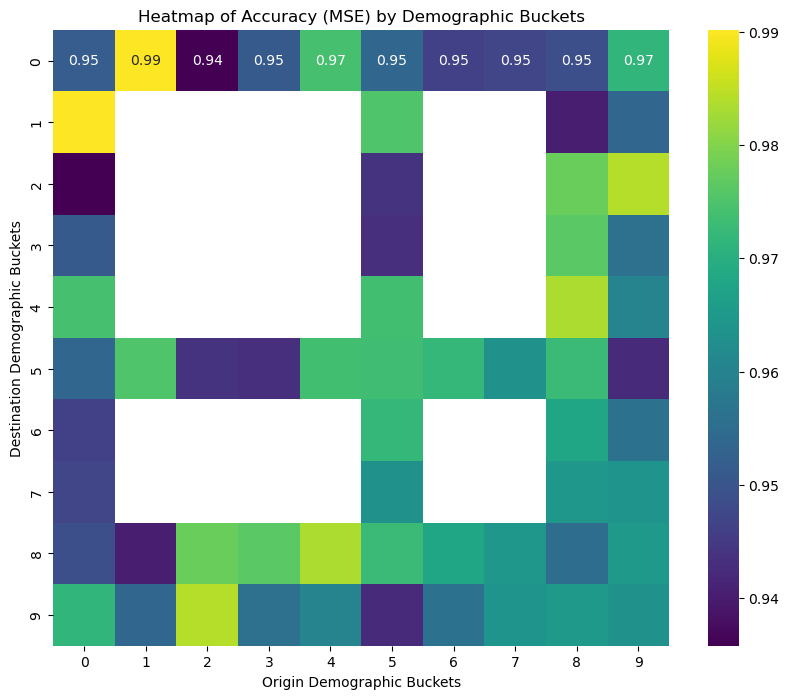

Fairness Metric (Variance of Accuracy): 0.00010336197048735238


In [5]:
from eval import FlowEvaluator

flows_path = 'dummy-data/flows.csv'
generated_flows_path = 'dummy-data/generated-flows.csv'
features_path = 'dummy-data/features.csv'
demographic_column = 'RPL_THEME1'

evaluator = FlowEvaluator(flows_path, generated_flows_path, features_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)
print(f'Fairness Metric (Variance of Accuracy): {fairness}')



In [1]:
import geopandas as gpd
tracts = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation.geojson")

In [3]:
tracts.head()

,STATEFP,COUNTYFP,COUNTYNAME,TRACTCE,GEOID20,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,ALANDMI,AWATERMI,INTPTLAT,INTPTLON,XCOORD,YCOORD,geometry
0,53,001,Adams,950100,53001950100,9501,Census Tract,G5020,S,1615246453,7701924,623.65017,2.97373,47.150512,-118.398327,2.164853e+06,671104.074676,"POLYGON ((2018032.07503 696360.32890, 2018022...."
1,53,001,Adams,950200,53001950200,9502,Census Tract,G5020,S,2629354892,2148452,1015.19964,0.82952,46.925269,-118.509265,2.138151e+06,585491.984120,"POLYGON ((2019612.57190 579263.24944, 2019614...."
2,53,001,Adams,950301,53001950301,9503.01,Census Tract,G5020,S,431966557,0,166.78323,0.00000,46.827801,-119.010979,2.013109e+06,548501.282473,"POLYGON ((1971869.38648 536440.09921, 1971903...."
3,53,001,Adams,950302,53001950302,9503.02,Census Tract,G5020,S,174575090,2213558,67.40382,0.85466,46.855092,-119.288159,1.949302e+06,560372.029820,"POLYGON ((1923507.39533 544426.33640, 1923492...."
4,53,001,Adams,950303,53001950303,9503.03,Census Tract,G5020,S,118609926,400491,45.79555,0.15463,46.771170,-119.269181,1.947509e+06,527925.824929,"POLYGON ((1923622.78891 530000.03394, 1923604...."


In [4]:
import geopandas as gpd

def extract_geojson_columns(input_path, output_path, columns):
    """
    Extracts specified columns from a GeoJSON file and saves them to a new file.

    Parameters:
    - input_path (str): Path to the input GeoJSON file.
    - output_path (str): Path where the output GeoJSON file will be saved.
    - columns (list): List of column names to retain in the output file.
    """
    # Load the GeoJSON file
    gdf = gpd.read_file(input_path)

    # Check if the specified columns exist in the DataFrame
    missing_cols = [col for col in columns if col not in gdf.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in the GeoJSON file: {missing_cols}")

    # Select the specified columns
    gdf_selected = gdf[columns]

    # Save the reduced GeoJSON file
    gdf_selected.to_file(output_path, driver='GeoJSON')

# Example usage
input_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation.geojson'
output_path = '/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_processed.geojson'
columns = ['GEOID20', 'XCOORD', 'YCOORD', 'geometry']

extract_geojson_columns(input_path, output_path, columns)


In [5]:
import geopandas as gpd
tracts = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_processed.geojson")

In [6]:
tracts.head()

,GEOID20,XCOORD,YCOORD,geometry
0,53001950100,2.164853e+06,671104.074676,"POLYGON ((2018032.07503 696360.32890, 2018022...."
1,53001950200,2.138151e+06,585491.984120,"POLYGON ((2019612.57190 579263.24944, 2019614...."
2,53001950301,2.013109e+06,548501.282473,"POLYGON ((1971869.38648 536440.09921, 1971903...."
3,53001950302,1.949302e+06,560372.029820,"POLYGON ((1923507.39533 544426.33640, 1923492...."
4,53001950303,1.947509e+06,527925.824929,"POLYGON ((1923622.78891 530000.03394, 1923604...."


In [8]:
import censusdata
import pandas
# Fetch census data for the specified region
# Define the tables of features to fetch
tables = {
    'B01003_001E': 'TotalPopulation'
}

data = censusdata.download('acs5', 2020,
                               censusdata.censusgeo([('state', '53'), ('county', '*'), ('tract', '*')]),
                               list(tables.keys()))

data.rename(columns=tables, inplace=True)

# Extract required GEOID information
data['GEOID'] = data.index.to_series().apply(lambda x: x.geo[0][1] + x.geo[1][1] + x.geo[2][1])
data.reset_index(drop=True, inplace=True)
data = data[['GEOID'] + list(tables.values())]

tessellation_path = "/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_processed.geojson"
# Load the tessellation GeoJSON
tessellation_gdf = gpd.read_file(tessellation_path)
tessellation_gdf.rename(columns={'GEOID20': 'GEOID'}, inplace=True)

# Merge the tessellation data with the census data on GEOID
merged_gdf = tessellation_gdf.merge(data[['GEOID', 'TotalPopulation']], on='GEOID', how='left')

# Save the updated GeoJSON
updated_geojson_path = tessellation_path.replace('.geojson', '_updated.geojson')
merged_gdf.to_file(updated_geojson_path, driver='GeoJSON')

print(f"Updated GeoJSON saved to {updated_geojson_path}")

Updated GeoJSON saved to /Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_processed_updated.geojson


In [ ]:
# Write a script that reads a geojson file with path "/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson"

In [7]:
import geopandas as gpd
tracts = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson")
tracts.head()

,GEOID,XCOORD,YCOORD,total_population,geometry
0,53001950100,2.164853e+06,671104.074676,2606,"POLYGON ((2018032.07503 696360.32890, 2018022...."
1,53001950200,2.138151e+06,585491.984120,1763,"POLYGON ((2019612.57190 579263.24944, 2019614...."
2,53001950301,2.013109e+06,548501.282473,1581,"POLYGON ((1971869.38648 536440.09921, 1971903...."
3,53001950302,1.949302e+06,560372.029820,2434,"POLYGON ((1923507.39533 544426.33640, 1923492...."
4,53001950303,1.947509e+06,527925.824929,2514,"POLYGON ((1923622.78891 530000.03394, 1923604...."


In [8]:
tracts.shape

(1784, 5)

In [9]:
import pandas as pd
flow = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/flow.csv")

In [3]:
tracts.rename(columns={'TotalPopulation': 'total_population'}, inplace=True)

In [1]:
tracts.to_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson", driver='GeoJSON')

NameError: name 'tracts' is not defined

In [5]:
import geopandas as gpd 
boundary = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/WA_State_Boundary.geojson")
boundary.head()

,OBJECTID,JURISDICT_SYST_ID,JURISDICT_TYPE_CD,JURISDICT_LABEL_NM,JURISDICT_NM,JURISDICT_DESG_CD,JURISDICT_FIPS_DESG_CD,JURISDICT_VACATED_FLG,EDIT_DATE,EDIT_STATUS,EDIT_WHO,GLOBALID,SHAPEAREA,SHAPELEN,geometry
0,223323,1,3,Washington,Washington State,53,53,None,2024-03-13 23:59:33+00:00,1,TSTE490,{8A0C1464-86BA-49FE-9F8F-3B782CF3A470},1.989098e+12,6.490124e+06,"POLYGON ((-117.03211 48.96046, -117.03226 48.9..."


In [ ]:
boundary.rename()

In [6]:
import geopandas as gpd 
boundary_old = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/boundary.geojson")
boundary_old.head()

,STATEFP10,PUMACE10,AFFGEOID10,GEOID10,NAME10,LSAD10,ALAND10,AWATER10,rowID,geometry
0,53,10800,7950000US5310800,5310800,Grant & Kittitas Counties,P0,12889669240,382373487,1,"MULTIPOLYGON (((-121.46595 47.36798, -121.4639..."
1,53,11503,7950000US5311503,5311503,Pierce County (West Central)--Lakewood City & ...,P0,377564437,36799117,2,"MULTIPOLYGON (((-122.64064 47.14941, -122.6386..."
2,53,10400,7950000US5310400,5310400,"Stevens, Okanogan, Pend Oreille & Ferry Counties",P0,29389070899,489249010,3,"MULTIPOLYGON (((-120.88206 48.97795, -120.8784..."
3,53,10902,7950000US5310902,5310902,Yakima County (Outer)--Sunnyside & Grandview C...,P0,10956431012,38823284,4,"MULTIPOLYGON (((-121.52384 46.08066, -121.5223..."
4,53,11609,7950000US5311609,5311609,"King County (Central)--Sammamish, Issaquah, Me...",P0,203389284,29361305,5,"MULTIPOLYGON (((-122.26763 47.60152, -122.2657..."


In [11]:
import pandas as pd

# Load the data
features_df = pd.read_csv('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/features.csv')
flows_df = pd.read_csv('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/flow.csv')

# Extract unique geoids from features file
feature_geoids = set(features_df['geoid'])

# Extract unique geoid_o and geoid_d from flows file
origin_geoids = set(flows_df['geoid_o'])
destination_geoids = set(flows_df['geoid_d'])

# Determine unmatched geoid_o and geoid_d
unmatched_origin_geoids = origin_geoids - feature_geoids
unmatched_destination_geoids = destination_geoids - feature_geoids

# Print the results
print(f"Number of unique 'geoid_o' without matching 'geoid' in features: {len(unmatched_origin_geoids)}")
print(f"Unmatched 'geoid_o': {unmatched_origin_geoids}")
print(f"Number of unique 'geoid_d' without matching 'geoid' in features: {len(unmatched_destination_geoids)}")
print(f"Unmatched 'geoid_d': {unmatched_destination_geoids}")



Number of unique 'geoid_o' without matching 'geoid' in features: 294
Unmatched 'geoid_o': {53015001600, 53061051905, 53033024000, 53061051400, 53053072905, 53053072906, 53061051915, 53007961100, 53033032203, 53045960200, 53009002000, 53033032208, 53033032210, 53061051923, 53061051924, 53061051925, 53033032212, 53033031703, 53033032214, 53073010200, 53067011610, 53033031706, 53063004700, 53073940000, 53061050401, 53055960100, 53011040805, 53011041318, 53033022500, 53021020200, 53033031205, 53067011621, 53053071406, 53053071407, 53011040302, 53005011503, 53053071410, 53077002802, 53033026100, 53011041327, 53057952302, 53035091000, 53033030202, 53037975100, 53061053504, 53065951300, 53033004100, 53033029700, 53055960300, 53077001800, 53033025102, 53049950800, 53033003600, 53027000400, 53057950800, 53063010900, 53033029204, 53061052503, 53033011800, 53049950300, 53053073500, 53001950300, 53033007200, 53063010402, 53061052003, 53077000300, 53033006700, 53045960300, 53067012212, 53033032309,

In [12]:
print(f"Number of unique 'geoid' in features: {len(feature_geoids)}")

Number of unique 'geoid' in features: 1784


In [13]:
print(f"Number of unique 'geoid' in features: {len(origin_geoids)}")

Number of unique 'geoid' in features: 1448


In [4]:
import geopandas as gpd
tessellation_whole = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson")
tessellation_whole.head()

,GEOID,XCOORD,YCOORD,total_population,geometry
0,53001950100,2.164853e+06,671104.074676,2606,"POLYGON ((2018032.07503 696360.32890, 2018022...."
1,53001950200,2.138151e+06,585491.984120,1763,"POLYGON ((2019612.57190 579263.24944, 2019614...."
2,53001950301,2.013109e+06,548501.282473,1581,"POLYGON ((1971869.38648 536440.09921, 1971903...."
3,53001950302,1.949302e+06,560372.029820,2434,"POLYGON ((1923507.39533 544426.33640, 1923492...."
4,53001950303,1.947509e+06,527925.824929,2514,"POLYGON ((1923622.78891 530000.03394, 1923604...."


In [5]:
import geopandas as gpd
tracts = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/processed_data/1/train/train_tessellation.geojson")
tracts.head()



,GEOID,XCOORD,YCOORD,total_population,geometry
0,53001950200,2.138151e+06,5.854920e+05,1763,"POLYGON ((2019612.57190 579263.24944, 2019614...."
1,53003960100,2.478878e+06,3.162291e+05,4320,"POLYGON ((2407498.76364 263743.17398, 2407478...."
2,53005011600,1.901597e+06,2.501444e+05,977,"POLYGON ((1801427.73593 184023.08357, 1801475...."
3,53007960100,1.619391e+06,1.011746e+06,2137,"POLYGON ((1501309.46441 1089100.77065, 1501448..."
4,53009940000,6.339100e+05,1.122490e+06,1638,"POLYGON ((607982.13184 1142175.55750, 608390.9..."


In [10]:
len(tracts)

49

In [20]:
import pandas as pd
flow = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/processed_data/1/train/flows/train_flow.csv")

In [21]:
flow.shape

(55035, 3)

In [22]:
flow_test = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/processed_data/1/test/flows/test_flow.csv")
flow_test.shape

(29820, 3)

In [23]:
flow_df = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/flow.csv")
flow_df.shape

(139972, 9)

In [24]:
import geopandas as gpd
tracts = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson")
tracts

,GEOID,XCOORD,YCOORD,total_population,geometry
0,53001950100,2.164853e+06,671104.074676,2606,"POLYGON ((2018032.07503 696360.32890, 2018022...."
1,53001950200,2.138151e+06,585491.984120,1763,"POLYGON ((2019612.57190 579263.24944, 2019614...."
2,53001950301,2.013109e+06,548501.282473,1581,"POLYGON ((1971869.38648 536440.09921, 1971903...."
3,53001950302,1.949302e+06,560372.029820,2434,"POLYGON ((1923507.39533 544426.33640, 1923492...."
4,53001950303,1.947509e+06,527925.824929,2514,"POLYGON ((1923622.78891 530000.03394, 1923604...."
...,...,...,...,...,...
1779,53077940003,1.548367e+06,333489.391023,3542,"POLYGON ((1382245.89172 370618.03304, 1382264...."
1780,53077940005,1.686814e+06,379232.681614,4727,"POLYGON ((1681785.22522 381158.56677, 1681814...."
1781,53077940006,1.689108e+06,383246.391621,4614,"POLYGON ((1682577.97845 386516.43742, 1683158...."
1782,53077940007,1.661261e+06,403698.539634,3880,"POLYGON ((1656016.30446 401823.77093, 1656016...."


In [25]:
tracts_withoutpop = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation.geojson")
tracts_withoutpop

,STATEFP,COUNTYFP,COUNTYNAME,TRACTCE,GEOID20,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,ALANDMI,AWATERMI,INTPTLAT,INTPTLON,XCOORD,YCOORD,geometry
0,53,001,Adams,950100,53001950100,9501,Census Tract,G5020,S,1615246453,7701924,623.65017,2.97373,47.150512,-118.398327,2.164853e+06,671104.074676,"POLYGON ((2018032.07503 696360.32890, 2018022...."
1,53,001,Adams,950200,53001950200,9502,Census Tract,G5020,S,2629354892,2148452,1015.19964,0.82952,46.925269,-118.509265,2.138151e+06,585491.984120,"POLYGON ((2019612.57190 579263.24944, 2019614...."
2,53,001,Adams,950301,53001950301,9503.01,Census Tract,G5020,S,431966557,0,166.78323,0.00000,46.827801,-119.010979,2.013109e+06,548501.282473,"POLYGON ((1971869.38648 536440.09921, 1971903...."
3,53,001,Adams,950302,53001950302,9503.02,Census Tract,G5020,S,174575090,2213558,67.40382,0.85466,46.855092,-119.288159,1.949302e+06,560372.029820,"POLYGON ((1923507.39533 544426.33640, 1923492...."
4,53,001,Adams,950303,53001950303,9503.03,Census Tract,G5020,S,118609926,400491,45.79555,0.15463,46.771170,-119.269181,1.947509e+06,527925.824929,"POLYGON ((1923622.78891 530000.03394, 1923604...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,53,077,Yakima,940003,53077940003,9400.03,Census Tract,G5020,S,4621265520,3847213,1784.28067,1.48542,46.259139,-120.849325,1.548367e+06,333489.391023,"POLYGON ((1382245.89172 370618.03304, 1382264...."
1780,53,077,Yakima,940005,53077940005,9400.05,Census Tract,G5020,S,5135226,0,1.98272,0.00000,46.373139,-120.316184,1.686814e+06,379232.681614,"POLYGON ((1681785.22522 381158.56677, 1681814...."
1781,53,077,Yakima,940006,53077940006,9400.06,Census Tract,G5020,S,4504123,0,1.73905,0.00000,46.384131,-120.307057,1.689108e+06,383246.391621,"POLYGON ((1682577.97845 386516.43742, 1683158...."
1782,53,077,Yakima,940007,53077940007,9400.07,Census Tract,G5020,S,5016436,0,1.93686,0.00000,46.440349,-120.417317,1.661261e+06,403698.539634,"POLYGON ((1656016.30446 401823.77093, 1656016...."


In [26]:
boundary = gpd.read_file("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/WA_State_Boundary.geojson")
boundary

,OBJECTID,JURISDICT_SYST_ID,JURISDICT_TYPE_CD,JURISDICT_LABEL_NM,JURISDICT_NM,JURISDICT_DESG_CD,JURISDICT_FIPS_DESG_CD,JURISDICT_VACATED_FLG,EDIT_DATE,EDIT_STATUS,EDIT_WHO,GLOBALID,SHAPEAREA,SHAPELEN,geometry
0,223323,1,3,Washington,Washington State,53,53,None,2024-03-13 23:59:33+00:00,1,TSTE490,{8A0C1464-86BA-49FE-9F8F-3B782CF3A470},1.989098e+12,6.490124e+06,"POLYGON ((-117.03211 48.96046, -117.03226 48.9..."


EPSG:4326


ValueError: aspect must be finite and positive 

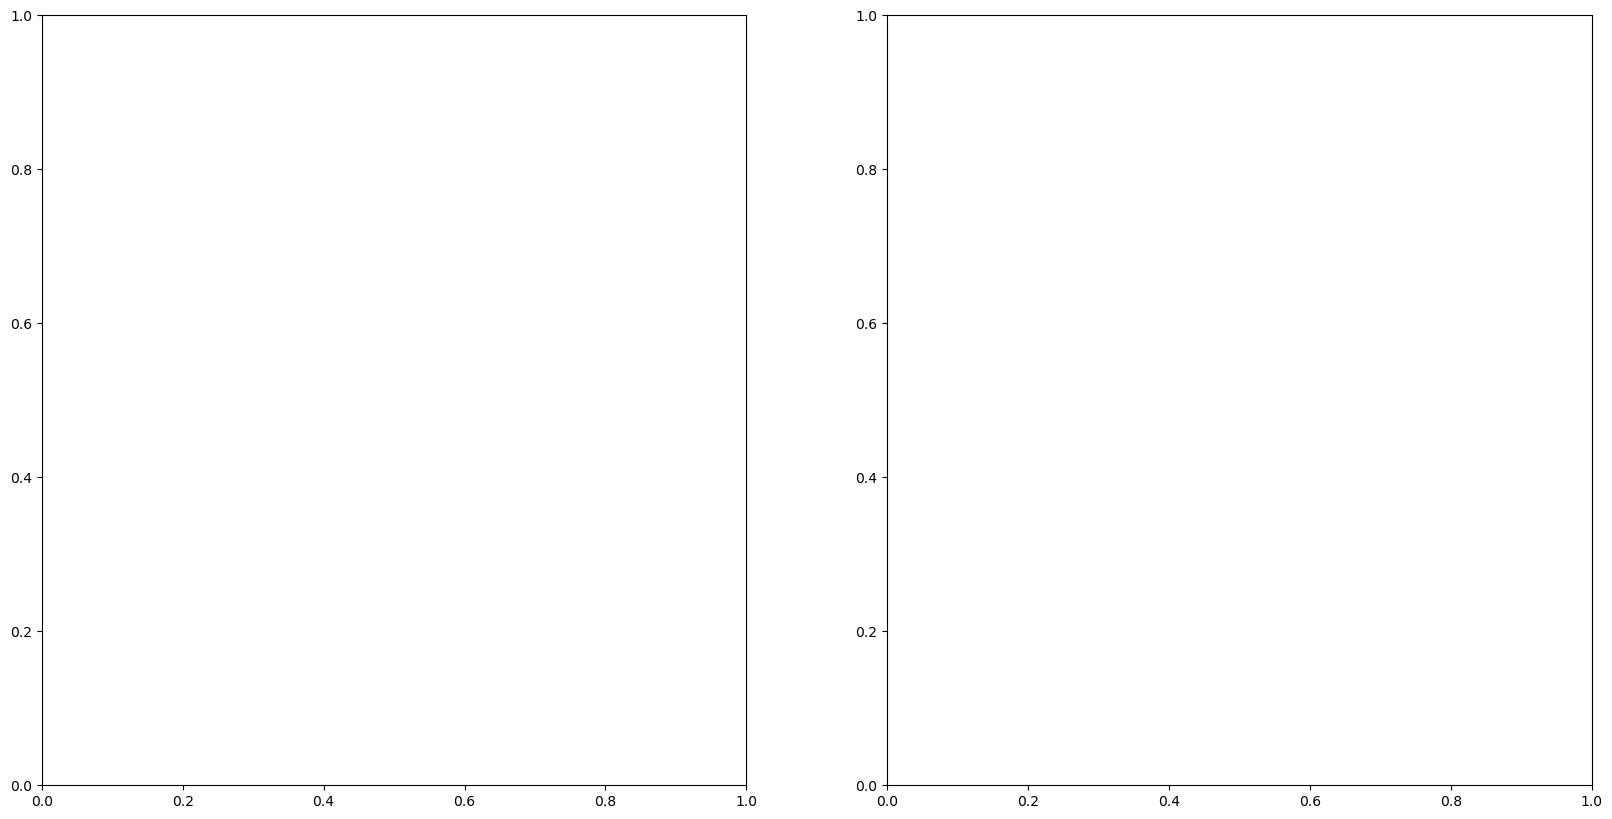

In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the flow.csv
flow_df = pd.read_csv('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/flow.csv')

# Load the tessellation.geojson
tessellation_gdf = gpd.read_file('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson')

print(tessellation_gdf.crs)
if tessellation_gdf.crs != "EPSG:4326":
    tessellation_gdf = tessellation_gdf.to_crs("EPSG:4326")

# Create GeoDataFrame for centroids in flow.csv
flow_gdf = gpd.GeoDataFrame(
    flow_df, 
    geometry=gpd.points_from_xy(flow_df.lng_o, flow_df.lat_o),
    crs="EPSG:4326"  # Assuming the coordinates are in WGS 84
)

# 1. Plot Census tracts from tessellations with XCOORD and YCOORD used to plot the centroids
# Convert tessellation XCOORD and YCOORD to geometry
tessellation_gdf['centroid'] = tessellation_gdf.apply(lambda row: Point(row.XCOORD, row.YCOORD), axis=1)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot tessellation polygons
tessellation_gdf.plot(ax=ax[0], color='lightgrey', edgecolor='black')

# Plot centroids from tessellations
tessellation_gdf.set_geometry('centroid').plot(ax=ax[0], color='red', markersize=5)
ax[0].set_title('Census Tracts with Centroids from tessellation.geojson')

# 2. Plot Census tract boundaries from tessellations and centroids from flow.csv
# Convert flow_df coordinates to centroid geometry
flow_gdf['centroid'] = flow_gdf.geometry

# Plot tessellation polygons
tessellation_gdf.plot(ax=ax[1], color='lightgrey', edgecolor='black')

# Plot centroids from flow.csv
flow_gdf.set_geometry('centroid').plot(ax=ax[1], color='blue', markersize=5)
ax[1].set_title('Census Tracts with Centroids from flow.csv')

# Show plot
plt.show()


In [41]:
tessellation_gdf


import pyproj
# Define the input and output coordinate systems
input_crs = pyproj.CRS.from_epsg(2927)  # Washington State Plane North (EPSG:2927)
output_crs = pyproj.CRS.from_epsg(4326)  # WGS84 (EPSG:4326)
# Create a transformer object for the coordinate conversion
transformer = pyproj.Transformer.from_crs(input_crs, output_crs, always_xy=True)
# Convert the X and Y coordinates to latitude and longitude
tessellation_gdf['lng'], tessellation_gdf['lat'] = transformer.transform(tessellation_gdf['XCOORD'].values, tessellation_gdf['YCOORD'].values)
# Print the converted coordinates
print(tessellation_gdf[['GEOID', 'lng', 'lat']])

            GEOID         lng        lat
0     53001950100 -118.391888  47.154400
1     53001950200 -118.507865  46.921646
2     53001950301 -119.010993  46.827807
3     53001950302 -119.265133  46.863373
4     53001950303 -119.274315  46.774492
...           ...         ...        ...
1779  53077940003 -120.863858  46.247271
1780  53077940005 -120.316198  46.373145
1781  53077940006 -120.307072  46.384137
1782  53077940007 -120.417332  46.440355
1783  53077940008 -120.423540  46.454228

[1784 rows x 3 columns]


Bounds: [ 579552.21068036   81836.44392898 2550984.25919408 1355597.21456634]
Any NaN coordinates in geometry? False


/var/folders/7k/j2gp05cs0397c9zct834x00r0000gn/T/ipykernel_40781/820829575.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tessellation_gdf['centroid'] = tessellation_gdf.geometry.centroid


Error plotting tessellation: aspect must be finite and positive 
Error plotting flow data: aspect must be finite and positive 


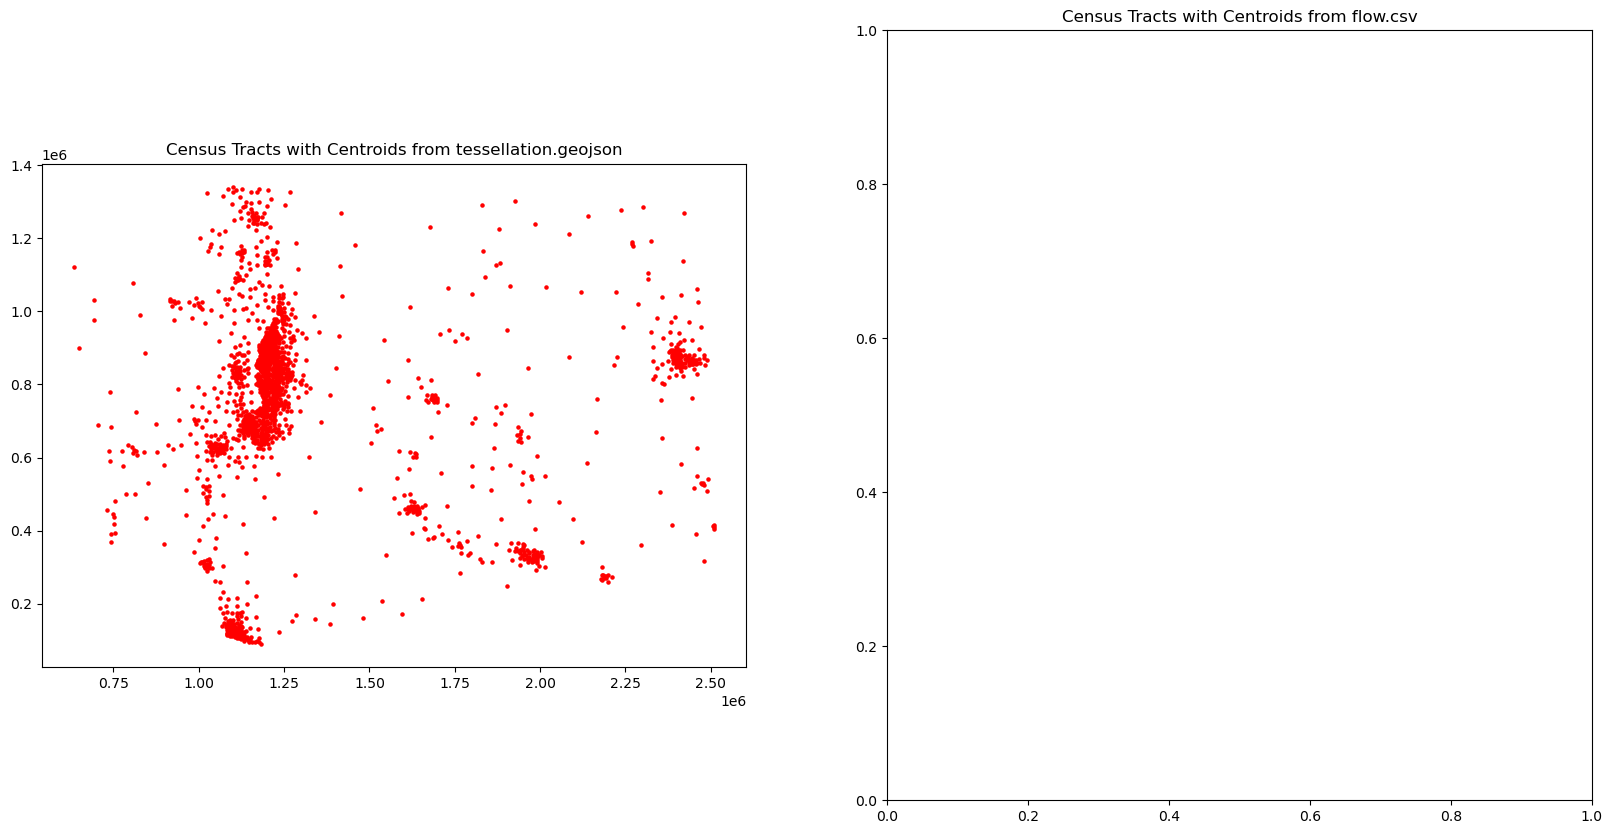

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the data
flow_df = pd.read_csv('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/flow.csv')
tessellation_gdf = gpd.read_file('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation_wpop.geojson')

# Check and possibly transform the CRS
if tessellation_gdf.crs != "EPSG:4326":
    tessellation_gdf = tessellation_gdf.to_crs("EPSG:4326")

# Check the total bounds of your geographic data and print them
print("Bounds:", tessellation_gdf.total_bounds)

# Check for any NaN values in your geographic data
print("Any NaN coordinates in geometry?", tessellation_gdf.geometry.isna().any())

# Create centroids in the tessellation_gdf
tessellation_gdf['centroid'] = tessellation_gdf.geometry.centroid

# Create GeoDataFrame for centroids from flow.csv
flow_gdf = gpd.GeoDataFrame(
    flow_df,
    geometry=gpd.points_from_xy(flow_df.lng_o, flow_df.lat_o),
    crs="EPSG:4326"
)

# Plot setup
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot tessellation polygons
try:
    tessellation_gdf.plot(ax=ax[0], color='lightgrey', edgecolor='black')
except Exception as e:
    print("Error plotting tessellation:", e)
    ax[0].set_aspect('auto')  # Adjust aspect ratio manually if needed

# Plot centroids from tessellations
tessellation_gdf.set_geometry('centroid').plot(ax=ax[0], color='red', markersize=5)
ax[0].set_title('Census Tracts with Centroids from tessellation.geojson')

# Plot tessellation polygons and centroids from flow.csv on the second subplot
try:
    tessellation_gdf.plot(ax=ax[1], color='lightgrey', edgecolor='black')
    flow_gdf.set_geometry('geometry').plot(ax=ax[1], color='blue', markersize=5)
except Exception as e:
    print("Error plotting flow data:", e)
    ax[1].set_aspect('auto')  # Adjust aspect ratio manually if needed

ax[1].set_title('Census Tracts with Centroids from flow.csv')

# Show plot
plt.show()



In [37]:
tracts = gpd.read_file('/Users/apoorvasheera/Documents/DSSG/Crowd Flow/crowdflow-fairness/data/WA/tessellation.geojson')

In [38]:
tracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
tracts.xcoord

In [34]:
from pyproj import Proj, transform

# Define the original (source) and target coordinate systems
# Here, EPSG:32610 is an example for UTM zone 10N. You'll need to replace it with the correct EPSG code for your data.

source_proj = Proj('epsg:32610')
target_proj = Proj('epsg:4326')  # WGS84, used for lat/lon

# Example coordinates (these need to be in your actual coordinate system)
x_coord = 2164852.5419029999
y_coord = 671104.07467600005

# Transform the coordinates
longitude, latitude = transform(source_proj, target_proj, x_coord, y_coord)
print(f"Longitude: {longitude}, Latitude: {latitude}")


Longitude: 5.868137464115737, Latitude: -108.12747993937734


/var/folders/7k/j2gp05cs0397c9zct834x00r0000gn/T/ipykernel_40781/3712015548.py:13: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longitude, latitude = transform(source_proj, target_proj, x_coord, y_coord)
